In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
import os
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, optimizer=fast_compile, floatX=float32'

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM
from keras.models import Sequential, Model
from keras.layers import merge, GRU, RepeatVector, Lambda, Reshape, Permute, Bidirectional, Activation, Dense, Dropout, Embedding, Flatten, Input, Merge, Convolution1D, MaxPooling1D, GlobalMaxPooling1D
import keras.backend as K
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.initializers import RandomUniform

import numpy as np
import pdb

import gensim, sklearn
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec, KeyedVectors

import codecs

import operator
from string import punctuation
from collections import defaultdict
import sys
import csv
import string
from nltk import tokenize as tokenize_nltk

In [178]:
ask_path = '/raid/data/niloofarsafi/project/ask.fm_data/'
wiki_path = '/raid/data/niloofarsafi/project/wiki/'
kaggle_path = '/raid/data/niloofarsafi/project/kaggle_new/'

seed_number = 1234
np.random.seed(seed_number)

# Model Hyperparameters
embedding_dim = 300
filter_sizes = (2, 3, 4)
num_filters = 100
dropout_prob = (0.0, 0.5)

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 25
max_words = 20000

# Word2Vec parameters 
min_word_count = 1
context = 10

### Evaluation Code

In [33]:
def final_labels2(y_actual, y_pred):
    y_tru=[]
    for lbl in y_actual:
        if lbl == 1:
            y_tru += ["negative"]
        else:
            y_tru += ["positive"] 
    y_te=[]
    for lbl in y_pred:
        if lbl[0]>lbl[1]:
            y_te += ["positive"]
        else:
            y_te += ["negative"]
    return y_tru, y_te

In [34]:
def report(le, y_test, y_pred):
        print("Classifation Report")

        
        target_names = le.classes_
        class_indices = {cls: idx for idx, cls in enumerate(le.classes_)}
        print(class_indices)

        print(metrics.classification_report(y_test, y_pred, target_names=target_names,
                                            labels=["" + str(class_indices[cls]) for cls in target_names]))
        
        
        print("============================================================")
        print("Confusion matrix")
        print("============================================================")
        print(target_names)
        print(confusion_matrix(y_test, y_pred,
            labels=[class_indices[cls] for cls in target_names]))

        precision_micro, recall_micro, fscore_micro, _ = \
        precision_recall_fscore_support(y_test, y_pred,
                                                                                           average='micro',
                                                                                           pos_label=None)
        precisions_macro, recalls_macro, fscore_macro, _ =\
        precision_recall_fscore_support(y_test, y_pred,
                                                                                           average='macro',
                                                                                           pos_label=None)
        precisions_weighted, recalls_weighted, fscore_weighted, _ =\
        precision_recall_fscore_support(y_test, y_pred,
                                                                                                    average='weighted',
                                                                                                    pos_label=None)
        
        measures = "p: %.4f r: %.4f f1: %.4f"
        print("Micro:  " + measures % (precision_micro, recall_micro, fscore_micro))
        print("Macro:  " + measures % (precisions_macro, recalls_macro, fscore_macro))
        print("Weight: " + measures % (precisions_weighted, recalls_weighted, fscore_weighted))

        print('Test Accuracy: %.4f' % accuracy_score(y_test, y_pred))
        print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
        print('Misclassified samples: %d' % (y_test != y_pred).sum())
        print("============================================================")

### Ask.fm data

In [184]:
train = []
train_lower = []
train_label = []

dev = []
dev_label = []

test = []
test_lower = []
test_label = []

text = ''

with open(ask_path+'train.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q = row['question']
        a = row['answer']
        for c in string.punctuation:
            q = q.replace(c," ")
            a = a.replace(c," ")
        
        q_l = row['question_sentiment']
        if q_l == "positive":
            lab1 = 0
        else:
            lab1 = 1
        a_l = row['answer_sentiment']
        if a_l == "positive":
            lab2 = 0
        else:
            lab2 = 1
        
        train.append(q)
        train_lower.append(q.lower())
        train_label.append(lab1)
        train.append(a)
        train_lower.append(a.lower())
        train_label.append(lab2)
        
#         text1 = ' '.join(train)

with open(ask_path+'dev.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q = row['question']
        a = row['answer']
        for c in string.punctuation:
            q = q.replace(c," ")
            a = a.replace(c," ")
            
        q_l = row['question_sentiment']
        if q_l == "positive":
            lab1 = 0
        else:
            lab1 = 1
        a_l = row['answer_sentiment']
        if a_l == "positive":
            lab2 = 0
        else:
            lab2 = 1
        
        train.append(q)
        train_lower.append(q.lower())
        train_label.append(lab1)
        train.append(a)
        train_lower.append(a.lower())
        train_label.append(lab2)
#         dev.append(q)
#         dev_label.append(lab1)
#         dev.append(a)
#         dev_label.append(lab2)
        
        text2 = ' '.join(train)
        
with open(ask_path+'test.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        q = row['question']
        a = row['answer']
        for c in string.punctuation:
            q = q.replace(c," ")
            a = a.replace(c," ")
            
        q_l = row['question_sentiment']
        if q_l == "positive":
            lab1 = 0
        else:
            lab1 = 1
        a_l = row['answer_sentiment']
        if a_l == "positive":
            lab2 = 0
        else:
            lab2 = 1
        
            
        test.append(q)
        test_label.append(lab1)
        test_lower.append(q.lower())
        test.append(a)
        test_label.append(lab2)
        test_lower.append(a.lower())
        
        text3 = ' '.join(test)

print('length of train: ', len(train))
# print('length of dev: ', len(dev))
print('length of test: ', len(test))
print('length of train_lower: ', len(train_lower))
# print('length of dev: ', len(dev))
print('length of test_lower: ', len(test_lower))

text = text2 + ' ' + text3

length of train:  7834
length of test:  3360
length of train_lower:  7834
length of test_lower:  3360


### character_based CNN

In [95]:
chars = sorted(list(set(text.lower())))
vocab_size = len(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print("Total number of chars:", len(text))
print("Vocabulary size:", vocab_size)
print(chars)

Total number of chars: 712849
Vocabulary size: 299
[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '¡', '©', '¯', '´', '¿', '×', 'à', 'á', 'â', 'ã', 'ä', 'å', 'é', 'ë', 'í', 'ï', 'ñ', 'ö', 'ø', 'ü', 'ý', 'ē', 'ę', 'ı', 'ś', 'ƚ', 'ɀ', 'ɑ', 'ɖ', 'ɘ', 'ə', 'ɛ', 'ɠ', 'ɪ', 'ɲ', 'ɳ', 'ɴ', 'ʀ', 'ʇ', 'ʝ', 'ʟ', 'α', 'ι', 'ρ', 'и', 'к', 'н', 'т', 'у', 'я', 'є', 'ѕ', 'أ', 'ا', 'ب', 'ج', 'ح', 'خ', 'د', 'ر', 'ز', 'س', 'ش', 'ض', 'ظ', 'ع', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ً', 'ڡ', 'ಠ', 'ค', 'ภ', 'เ', 'ლ', 'ᴇ', 'ᴏ', 'ᴠ', '\u200e', '\u200f', '’', '“', '”', '•', '…', '‿', '⃟', '℅', 'ℒ', 'ℓ', '™', '↓', '∞', 'ⓐ', 'ⓔ', 'ⓘ', 'ⓛ', 'ⓝ', 'ⓣ', '◠', '☁', '☝', '☣', '☤', '☥', '☺', '☻', '♓', '♕', '♛', '♡', '♥', '⚾', '✊', '✋', '✌', '✔', '✖', '✨', '✿', '❀', '❄', '❊', '❗', '❤', '❥', '⬇', '⭐', 'ツ', '유', '진', '\ue011', '\ue018', '\ue049', '\ue13d', '\ue253', '\ue4

In [96]:
def char_mapping(char_indices, documents):
    X = []
    for doc in documents:
        doc_vec = []
        for word in doc.lower():
            for token in word:
                doc_vec.append(char_indices[token])
        X.append(doc_vec)
    return X
                

char_train = char_mapping(char_indices, train)
# char_dev = char_mapping(char_indices, dev)
char_test = char_mapping(char_indices, test)
print(char_train[:2])

[[18, 11, 18, 11, 0, 29, 18, 19, 30, 0, 23, 35, 0, 12, 11, 14, 0, 30, 18, 11, 30, 0, 33, 11, 29, 0, 23, 15, 123, 37, 37, 29, 25, 22, 25, 23, 25, 24, 0, 21, 19, 11], [25, 18, 18, 18, 0, 29, 25, 22, 25, 23, 25, 24, 24, 24, 24, 24, 0, 0, 22, 25, 22, 0, 30, 18, 11, 24, 21, 29, 0, 29, 30, 28, 11, 24, 17, 15, 28, 0, 0]]


In [97]:
maxlen = 150

char_x_train = pad_sequences(char_train, maxlen=maxlen)
# char_x_dev = pad_sequences(char_dev, maxlen=maxlen)
char_x_test  = pad_sequences(char_test, maxlen=maxlen)

# labels = train_label + dev_label
labels = train_label
print(np.unique(labels))

c_weight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(labels), labels)
print(c_weight)

class_weights = {}
for num, w in enumerate(c_weight):
    class_weights[num] = w
print(class_weights)

train_y = keras.utils.to_categorical(train_label, 2)
# dev_y = keras.utils.to_categorical(dev_label, 2)
test_y = keras.utils.to_categorical(test_label, 2)

[0 1]
[ 0.61126717  2.74684432]
{0: 0.61126716604244691, 1: 2.7468443197755961}


In [344]:
def get_input_layer(shape, name):
    return Input(shape=shape, dtype='int32', name='{}_input'.format(name))

def pretrained_embedding_layer(embeddings, input_layer, input_len, name):
    embed_layer = Embedding(embeddings.shape[0], 
                           embeddings.shape[1], 
                           input_length=input_len, 
                           weights=[embeddings],
                           trainable=False,
                           name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.25, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer
    
    
def rand_uniform_embedding_layer(input_layer, input_dim, output_dim, input_len, name):
    uniform = RandomUniform(seed=seed_number, 
                            minval=-np.sqrt(3/output_dim),  # Suggested by
                            maxval= np.sqrt(3/output_dim))  # He et al (2015) 
    embed_layer = Embedding(input_dim=input_dim, 
                            output_dim=output_dim,
                            input_length=input_len, 
                            embeddings_initializer=uniform,
                            trainable=False,
                            name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.25, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer

#64
def get_char_cnn(embedded, name, filters=100, kernel_size=4, dense_units=32, convs=3):
    conv_net = embedded
    for _ in range(convs):
        conv_net = Convolution1D(filters=filters, kernel_size=kernel_size, activation='relu')(conv_net)
    conv_net = GlobalAveragePooling1D()(conv_net)
    conv_net = Dense(dense_units, activation='relu', name='{}_dense'.format(name))(conv_net)
    return conv_net

def get_char_cnn2(embedded, name, filters=100, kernel_size=[4], dense_units=32):
    z = embedded
    conv_blocks = []
    for ks in kernel_size:
        conv_net = Convolution1D(filters=filters, kernel_size=ks, activation='relu')(z)
        conv_net = GlobalAveragePooling1D()(conv_net)
        conv_blocks.append(conv_net)
    z2 = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    return z2



char_dim = 40
char_input = get_input_layer((maxlen,), 'char_ask')
char_embed = rand_uniform_embedding_layer(char_input, 
                                                len(char_indices), 
                                                char_dim, 
                                                maxlen, 
                                                'char_ask')
char_encoded = char_embed

char_encoded = get_char_cnn(char_encoded, 'char_encoded', kernel_size=4, convs=2)
# z = Dropout(dropout_prob[1])(char_encoded)
model_output = Dense(2, activation="softmax")(char_encoded)

char_encoder = Model(char_input, model_output)
char_encoder.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
char_encoder.summary(85)

_____________________________________________________________________________________
Layer (type)                          Output Shape                      Param #      
char_ask_input (InputLayer)           (None, 150)                       0            
_____________________________________________________________________________________
char_ask_embed (Embedding)            (None, 150, 40)                   11960        
_____________________________________________________________________________________
char_ask_embed_dropout (Dropout)      (None, 150, 40)                   0            
_____________________________________________________________________________________
conv1d_108 (Conv1D)                   (None, 147, 100)                  16100        
_____________________________________________________________________________________
conv1d_109 (Conv1D)                   (None, 144, 100)                  40100        
______________________________________________________

In [345]:
num_epochs = 50

char_weight_file = '/raid/data/niloofarsafi/project/first_char_cnn_balanced_weights.h5'

checkpoint = ModelCheckpoint(char_weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history_char = char_encoder.fit(char_x_train, train_y, batch_size=batch_size, 
                              epochs=num_epochs,
                              class_weight=class_weights, 
                              validation_split=0.2, 
                              verbose=2, callbacks=[early, checkpoint])

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.68051, saving model to /raid/data/niloofarsafi/project/first_char_cnn_balanced_weights.h5
 - 3s - loss: 0.6842 - acc: 0.5858 - val_loss: 0.6805 - val_acc: 0.7186
Epoch 2/50
Epoch 00002: val_loss improved from 0.68051 to 0.64030, saving model to /raid/data/niloofarsafi/project/first_char_cnn_balanced_weights.h5
 - 3s - loss: 0.6615 - acc: 0.6569 - val_loss: 0.6403 - val_acc: 0.7026
Epoch 3/50
Epoch 00003: val_loss improved from 0.64030 to 0.62039, saving model to /raid/data/niloofarsafi/project/first_char_cnn_balanced_weights.h5
 - 3s - loss: 0.6284 - acc: 0.6965 - val_loss: 0.6204 - val_acc: 0.6401
Epoch 4/50
Epoch 00004: val_loss improved from 0.62039 to 0.59365, saving model to /raid/data/niloofarsafi/project/first_char_cnn_balanced_weights.h5
 - 3s - loss: 0.6160 - acc: 0.6954 - val_loss: 0.5937 - val_acc: 0.7339
Epoch 5/50
Epoch 00005: val_loss improved from 0.59365 to 0.58884, s

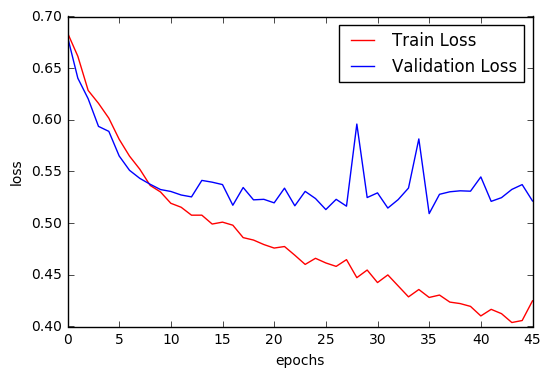

In [346]:
char_train_loss = history_char.history["loss"]
char_val_loss = history_char.history["val_loss"]
plt.plot(range(len(char_train_loss)), char_train_loss, color="red", label="Train Loss")
plt.plot(range(len(char_train_loss)), char_val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

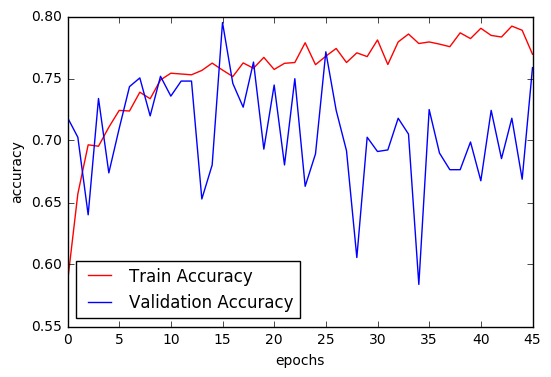

In [347]:
char_train_acc = history_char.history["acc"]
char_val_acc = history_char.history["val_acc"]
plt.plot(range(len(char_train_acc)), char_train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(char_train_acc)), char_val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [348]:
char_encoder.load_weights(char_weight_file)
predicted = char_encoder.predict(char_x_test)
label_encoder = LabelEncoder()
# y_tru, static_y_te = final_labels(test_label, static_predicted, 0.49)
y_tru, char_y_te = final_labels2(test_label, predicted)
# print(len(y_tru))
# print(len(y_te))
char_y_te = label_encoder.fit_transform(char_y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, char_y_te)

Classifation Report
{'negative': 0, 'positive': 1}
             precision    recall  f1-score   support

   negative       0.40      0.80      0.53       597
   positive       0.95      0.73      0.83      2763

avg / total       0.85      0.75      0.77      3360

Confusion matrix
['negative' 'positive']
[[ 480  117]
 [ 734 2029]]
Micro:  p: 0.7467 r: 0.7467 f1: 0.7467
Macro:  p: 0.6704 r: 0.7692 f1: 0.6784
Weight: p: 0.8477 r: 0.7467 f1: 0.7740
Test Accuracy: 0.7467
ROC AUC: 0.769
Misclassified samples: 851


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [202]:
all_data = train + test
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(all_data)

train_sequence = tokenizer.texts_to_sequences(train)
# dev_sequence = tokenizer.texts_to_sequences(dev)
test_sequence = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index

vocabulary_inv = dict((v, k) for k, v in word_index.items())
vocabulary_inv[0] = "<PAD/>"
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

Vocabulary Size: 10997


In [203]:
# label = train_label + dev_label
train_data = pad_sequences(train_sequence, maxlen=sequence_length, padding="post", truncating="post")
# dev_data = pad_sequences(dev_sequence, maxlen=sequence_length, padding="post", truncating="post")
test_data = pad_sequences(test_sequence, maxlen=sequence_length, padding="post", truncating="post")
# labels = np.array

In [204]:
labels = train_label 
print(np.unique(labels))
c_weight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(labels), labels)
print(c_weight)
class_weights = {}
for num, w in enumerate(c_weight):
    class_weights[num] = w
print(class_weights)


train_y = keras.utils.to_categorical(train_label, 2)
# dev_y = keras.utils.to_categorical(dev_label, 2)
test_y = keras.utils.to_categorical(test_label, 2)
print('y_train shape: ', train_y.shape)

[0 1]
[ 0.61126717  2.74684432]
{0: 0.61126716604244691, 1: 2.7468443197755961}
y_train shape:  (7834, 2)


### CNN Random

In [210]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

output_dim = 40

uniform = RandomUniform(seed=seed_number, 
                            minval=-np.sqrt(3/output_dim),  # Suggested by
                            maxval= np.sqrt(3/output_dim))  # He et al (2015) 

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, 
                            embeddings_initializer=uniform,
                            name="embedding")
z = embedding_layer(model_input)
# z = Dropout(0.25)(z)
num_filters = 100
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
#     conv = Dense(32, activation='relu')(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]


# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(2, activation="softmax")(z)

# Model compilation
model_rand = Model(model_input, model_output)
model_rand.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_rand.summary(85)

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_15 (InputLayer)       (None, 25)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 25, 300)   3299100   input_15[0][0]               
_____________________________________________________________________________________
conv1d_71 (Conv1D)          (None, 24, 100)   60100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_72 (Conv1D)          (None, 23, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_73 (Conv1D)          (None, 22, 100)   120100    embedding[0][0]              
______________________________________________________

In [211]:
num_epochs = 50

rand_weight_file = '/raid/data/niloofarsafi/project/cnn_rand_balanced_weights.h5'

checkpoint = ModelCheckpoint(rand_weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history_rand = model_rand.fit(train_data, train_y, batch_size=batch_size, 
                              epochs=num_epochs,
                              class_weight=class_weights, 
                              validation_split=0.2, 
                              verbose=2, callbacks=[early, checkpoint])

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.55950, saving model to /raid/data/niloofarsafi/project/cnn_rand_balanced_weights.h5
 - 2s - loss: 0.6592 - acc: 0.6293 - val_loss: 0.5595 - val_acc: 0.6777
Epoch 2/50
Epoch 00002: val_loss improved from 0.55950 to 0.52326, saving model to /raid/data/niloofarsafi/project/cnn_rand_balanced_weights.h5
 - 2s - loss: 0.4693 - acc: 0.7812 - val_loss: 0.5233 - val_acc: 0.7741
Epoch 3/50
Epoch 00003: val_loss did not improve
 - 2s - loss: 0.3687 - acc: 0.8447 - val_loss: 0.5251 - val_acc: 0.7715
Epoch 4/50
Epoch 00004: val_loss did not improve
 - 2s - loss: 0.2646 - acc: 0.8963 - val_loss: 0.5977 - val_acc: 0.8168
Epoch 5/50
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.1956 - acc: 0.9247 - val_loss: 0.6677 - val_acc: 0.8226
Epoch 6/50
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.1576 - acc: 0.9400 - val_loss: 0.6907 - val_acc: 0.8060
Epoch 7/50
Epoch 00007: val_loss did not

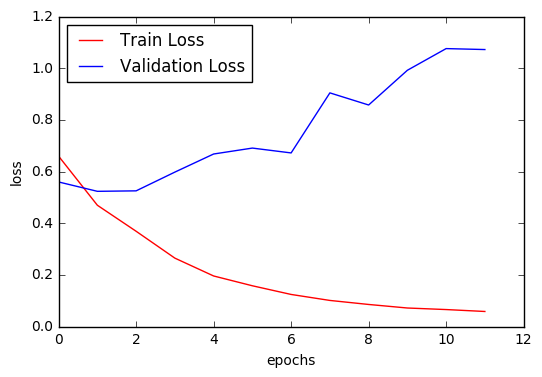

In [212]:
rand_train_loss = history_rand.history["loss"]
rand_val_loss = history_rand.history["val_loss"]
plt.plot(range(len(rand_train_loss)), rand_train_loss, color="red", label="Train Loss")
plt.plot(range(len(rand_train_loss)), rand_val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

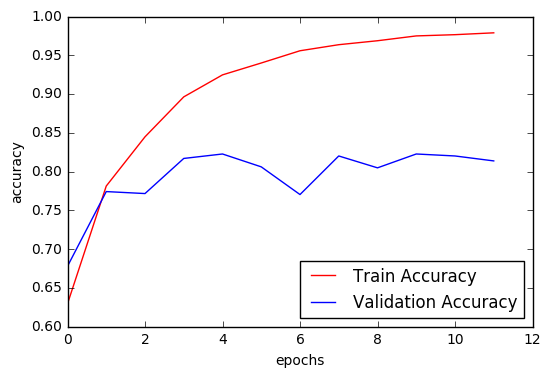

In [213]:
rand_train_acc = history_rand.history["acc"]
rand_val_acc = history_rand.history["val_acc"]
plt.plot(range(len(rand_train_acc)), rand_train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(rand_train_acc)), rand_val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [214]:
model_rand.load_weights(rand_weight_file)
predicted = model_rand.predict(test_data)
label_encoder = LabelEncoder()
# y_tru, y_te = final_labels(test_label, predicted, 0.5)
y_tru, y_te = final_labels2(test_label, predicted)
# print(len(y_tru))
# print(len(y_te))
y_te = label_encoder.fit_transform(y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, y_te)

Classifation Report
{'negative': 0, 'positive': 1}
             precision    recall  f1-score   support

   negative       0.45      0.71      0.55       597
   positive       0.93      0.81      0.87      2763

avg / total       0.84      0.79      0.81      3360

Confusion matrix
['negative' 'positive']
[[ 422  175]
 [ 519 2244]]
Micro:  p: 0.7935 r: 0.7935 f1: 0.7935
Macro:  p: 0.6881 r: 0.7595 f1: 0.7074
Weight: p: 0.8425 r: 0.7935 f1: 0.8097
Test Accuracy: 0.7935
ROC AUC: 0.760
Misclassified samples: 694


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [221]:
googleNews = False

if googleNews:
    print("Using GoogleNews word2vec representations!")
    embedding_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    for key, word in vocabulary_inv.items():
        if word in embedding_model:
            embedding_weights[key] = embedding_model[word]
        else:
            oov_counter += 1
            embedding_weights[key] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
            
    print('Null word embeddings: %d' % oov_counter)

    
else:
    pretrained = 'AskWordModel.model'
    embedding_model = KeyedVectors.load(pretrained)
    oov_counter = 0
    embedding_weights = {}
    print(embedding_model.vector_size)
    for key, word in vocabulary_inv.items():
        if word in embedding_model:
            embedding_weights[key] = embedding_model[word]
        else:
            oov_counter += 1
            embedding_weights[key] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
            
    print('Null word embeddings: %d' % oov_counter)

300
Null word embeddings: 3410


In [258]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
# print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer.set_weights([weights])
embedding_layer.trainable = False
# z = Dropout(0.1)(z)
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
#     conv = Dense(32, activation='relu')(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(2, activation="softmax")(z)

# Model compilation
model_static = Model(model_input, model_output)
model_static.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_static.summary(85)

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_24 (InputLayer)       (None, 25)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 25, 300)   3299100   input_24[0][0]               
_____________________________________________________________________________________
conv1d_98 (Conv1D)          (None, 24, 100)   60100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_99 (Conv1D)          (None, 23, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_100 (Conv1D)         (None, 22, 100)   120100    embedding[0][0]              
______________________________________________________

In [259]:
num_epochs = 50

history_static = {}

static_weight_file = '/raid/data/niloofarsafi/project/cnn_static_balanced_weights.h5'

checkpoint = ModelCheckpoint(static_weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history_static = model_static.fit(train_data, train_y, batch_size=batch_size, epochs=num_epochs,
          class_weight=class_weights, validation_split=0.2, verbose=2, callbacks=[early, checkpoint])

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.90388, saving model to /raid/data/niloofarsafi/project/cnn_static_balanced_weights.h5
 - 2s - loss: 2.0638 - acc: 0.6239 - val_loss: 0.9039 - val_acc: 0.6975
Epoch 2/50
Epoch 00002: val_loss improved from 0.90388 to 0.81727, saving model to /raid/data/niloofarsafi/project/cnn_static_balanced_weights.h5
 - 2s - loss: 1.1975 - acc: 0.7220 - val_loss: 0.8173 - val_acc: 0.7230
Epoch 3/50
Epoch 00003: val_loss did not improve
 - 2s - loss: 0.8326 - acc: 0.7645 - val_loss: 0.8542 - val_acc: 0.8041
Epoch 4/50
Epoch 00004: val_loss improved from 0.81727 to 0.66469, saving model to /raid/data/niloofarsafi/project/cnn_static_balanced_weights.h5
 - 2s - loss: 0.5785 - acc: 0.8058 - val_loss: 0.6647 - val_acc: 0.7543
Epoch 5/50
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.4253 - acc: 0.8388 - val_loss: 0.7166 - val_acc: 0.8066
Epoch 6/50
Epoch 00006: val_loss did not improve
 - 2s - los

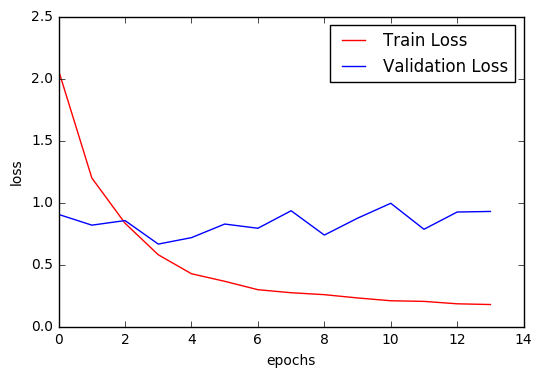

In [260]:
static_train_loss = history_static.history["loss"]
static_val_loss = history_static.history["val_loss"]
plt.plot(range(len(static_train_loss)), static_train_loss, color="red", label="Train Loss")
plt.plot(range(len(static_train_loss)), static_val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

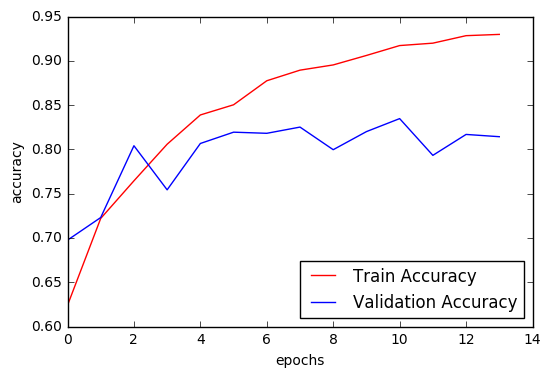

In [261]:
static_train_acc = history_static.history["acc"]
static_val_acc = history_static.history["val_acc"]
plt.plot(range(len(static_train_acc)), static_train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(static_train_acc)), static_val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [262]:
model_static.load_weights(static_weight_file)
static_predicted = model_static.predict(test_data)
label_encoder = LabelEncoder()
# y_tru, static_y_te = final_labels(test_label, static_predicted, 0.49)
y_tru, static_y_te = final_labels2(test_label, static_predicted)
# print(len(y_tru))
# print(len(y_te))
static_y_te = label_encoder.fit_transform(static_y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, static_y_te)

Classifation Report
{'negative': 0, 'positive': 1}
             precision    recall  f1-score   support

   negative       0.42      0.75      0.54       597
   positive       0.94      0.77      0.85      2763

avg / total       0.84      0.77      0.79      3360

Confusion matrix
['negative' 'positive']
[[ 449  148]
 [ 627 2136]]
Micro:  p: 0.7693 r: 0.7693 f1: 0.7693
Macro:  p: 0.6762 r: 0.7626 f1: 0.6916
Weight: p: 0.8432 r: 0.7693 f1: 0.7914
Test Accuracy: 0.7693
ROC AUC: 0.763
Misclassified samples: 775


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [263]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
# print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer.set_weights([weights])
embedding_layer.trainable = True

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(2, activation="softmax")(z)

# Model compilation
model_non_static = Model(model_input, model_output)
model_non_static.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_non_static.summary(85)

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_25 (InputLayer)       (None, 25)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 25, 300)   3299100   input_25[0][0]               
_____________________________________________________________________________________
conv1d_101 (Conv1D)         (None, 24, 100)   60100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_102 (Conv1D)         (None, 23, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_103 (Conv1D)         (None, 22, 100)   120100    embedding[0][0]              
______________________________________________________

In [264]:
num_epochs = 50

history_non_static = {}

non_static_weight_file = '/raid/data/niloofarsafi/project/cnn_non_static_balanced_weights.h5'

checkpoint = ModelCheckpoint(non_static_weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history_non_static = model_non_static.fit(train_data, train_y, batch_size=batch_size, epochs=num_epochs,
          class_weight=class_weights, validation_split=0.2, verbose=2, callbacks=[early, checkpoint])

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.92402, saving model to /raid/data/niloofarsafi/project/cnn_non_static_balanced_weights.h5
 - 2s - loss: 2.0443 - acc: 0.6276 - val_loss: 0.9240 - val_acc: 0.7435
Epoch 2/50
Epoch 00002: val_loss improved from 0.92402 to 0.87678, saving model to /raid/data/niloofarsafi/project/cnn_non_static_balanced_weights.h5
 - 2s - loss: 1.2163 - acc: 0.7281 - val_loss: 0.8768 - val_acc: 0.7658
Epoch 3/50
Epoch 00003: val_loss improved from 0.87678 to 0.75255, saving model to /raid/data/niloofarsafi/project/cnn_non_static_balanced_weights.h5
 - 2s - loss: 0.7714 - acc: 0.7792 - val_loss: 0.7526 - val_acc: 0.7837
Epoch 4/50
Epoch 00004: val_loss improved from 0.75255 to 0.74621, saving model to /raid/data/niloofarsafi/project/cnn_non_static_balanced_weights.h5
 - 2s - loss: 0.5342 - acc: 0.8111 - val_loss: 0.7462 - val_acc: 0.8207
Epoch 5/50
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.423

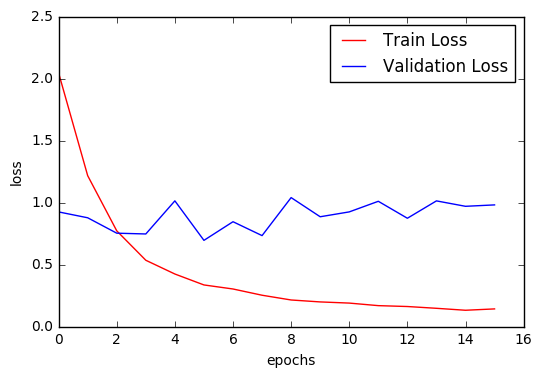

In [265]:
non_static_train_loss = history_non_static.history["loss"]
non_static_val_loss = history_non_static.history["val_loss"]
plt.plot(range(len(non_static_train_loss)), non_static_train_loss, color="red", label="Train Loss")
plt.plot(range(len(non_static_train_loss)), non_static_val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

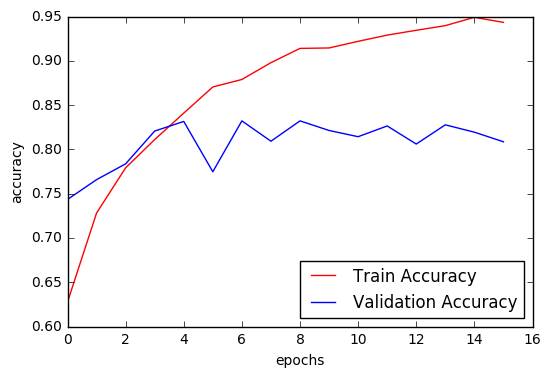

In [266]:
non_static_train_acc = history_non_static.history["acc"]
non_static_val_acc = history_non_static.history["val_acc"]
plt.plot(range(len(non_static_train_acc)), non_static_train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(non_static_train_acc)), non_static_val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [267]:
model_non_static.load_weights(non_static_weight_file)
non_static_predicted = model_non_static.predict(test_data)
label_encoder = LabelEncoder()
# y_tru, non_static_y_te = final_labels(test_label, non_static_predicted, 0.25)
y_tru, non_static_y_te = final_labels2(test_label, non_static_predicted)
# print(len(y_tru))
# print(len(y_te))
non_static_y_te = label_encoder.fit_transform(non_static_y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, non_static_y_te)

Classifation Report
{'negative': 0, 'positive': 1}
             precision    recall  f1-score   support

   negative       0.43      0.72      0.54       597
   positive       0.93      0.80      0.86      2763

avg / total       0.84      0.78      0.80      3360

Confusion matrix
['negative' 'positive']
[[ 428  169]
 [ 562 2201]]
Micro:  p: 0.7824 r: 0.7824 f1: 0.7824
Macro:  p: 0.6805 r: 0.7568 f1: 0.6985
Weight: p: 0.8405 r: 0.7824 f1: 0.8010
Test Accuracy: 0.7824
ROC AUC: 0.757
Misclassified samples: 731


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


### BiLSTM

In [319]:
ask_input = get_input_layer((sequence_length,), 'word_ask')
ask_embed = pretrained_embedding_layer(weights, 
                                           ask_input, 
                                           sequence_length, 
                                           'word_ask')

word_encoded = Bidirectional(LSTM(100, 
                                  return_sequences=False, 
                                  dropout=0.2, 
                                  recurrent_dropout=0.2), 
                             name='word_encoded_blstm')(ask_embed)

word_encoded = Dropout(0.5, name='word_encoded_blstm_dropout')(word_encoded)

ask_output = Dense(2, activation="softmax")(word_encoded)

rnn_model = Model(ask_input, ask_output)
rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

rnn_model.summary(80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
word_ask_input (InputLayer)         (None, 25)                      0           
________________________________________________________________________________
word_ask_embed (Embedding)          (None, 25, 300)                 3299100     
________________________________________________________________________________
word_ask_embed_dropout (Dropout)    (None, 25, 300)                 0           
________________________________________________________________________________
word_encoded_blstm (Bidirectional)  (None, 200)                     320800      
________________________________________________________________________________
word_encoded_blstm_dropout (Dropout (None, 200)                     0           
________________________________________________________________________________
dense_66 (Dense)            

In [320]:
num_epochs = 50

history_rnn = {}

rnn_weight_file = '/raid/data/niloofarsafi/project/BiLSTM_balanced_weights.h5'

checkpoint = ModelCheckpoint(rnn_weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history_rnn = rnn_model.fit(train_data, train_y, batch_size=500, epochs=num_epochs,
          class_weight=class_weights, validation_split=0.2, verbose=2, callbacks=[early, checkpoint])

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.59501, saving model to /raid/data/niloofarsafi/project/BiLSTM_balanced_weights.h5
 - 13s - loss: 0.6878 - acc: 0.5950 - val_loss: 0.5950 - val_acc: 0.7045
Epoch 2/50
Epoch 00002: val_loss improved from 0.59501 to 0.57072, saving model to /raid/data/niloofarsafi/project/BiLSTM_balanced_weights.h5
 - 13s - loss: 0.6181 - acc: 0.6734 - val_loss: 0.5707 - val_acc: 0.6548
Epoch 3/50
Epoch 00003: val_loss improved from 0.57072 to 0.55032, saving model to /raid/data/niloofarsafi/project/BiLSTM_balanced_weights.h5
 - 13s - loss: 0.5908 - acc: 0.6852 - val_loss: 0.5503 - val_acc: 0.6828
Epoch 4/50
Epoch 00004: val_loss improved from 0.55032 to 0.53826, saving model to /raid/data/niloofarsafi/project/BiLSTM_balanced_weights.h5
 - 13s - loss: 0.5647 - acc: 0.7045 - val_loss: 0.5383 - val_acc: 0.6675
Epoch 5/50
Epoch 00005: val_loss improved from 0.53826 to 0.52287, saving model to /raid/data/ni

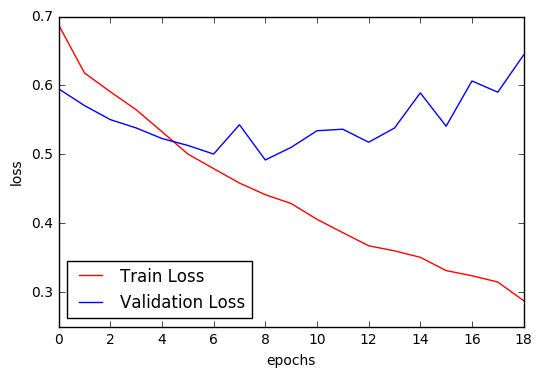

In [321]:
rnn_train_loss = history_rnn.history["loss"]
rnn_val_loss = history_rnn.history["val_loss"]
plt.plot(range(len(rnn_train_loss)), rnn_train_loss, color="red", label="Train Loss")
plt.plot(range(len(rnn_train_loss)), rnn_val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

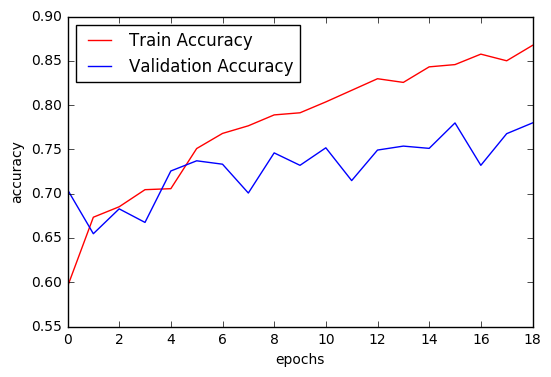

In [322]:
rnn_train_acc = history_rnn.history["acc"]
rnn_val_acc = history_rnn.history["val_acc"]
plt.plot(range(len(rnn_train_acc)), rnn_train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(rnn_train_acc)), rnn_val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [323]:
rnn_model.load_weights(rnn_weight_file)
rnn_predicted = rnn_model.predict(test_data)
label_encoder = LabelEncoder()
# y_tru, static_y_te = final_labels(test_label, static_predicted, 0.49)
y_tru, rnn_y_te = final_labels2(test_label, rnn_predicted)
# print(len(y_tru))
# print(len(y_te))
rnn_y_te = label_encoder.fit_transform(rnn_y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, rnn_y_te)

Classifation Report
{'negative': 0, 'positive': 1}
             precision    recall  f1-score   support

   negative       0.42      0.81      0.55       597
   positive       0.95      0.76      0.84      2763

avg / total       0.85      0.77      0.79      3360

Confusion matrix
['negative' 'positive']
[[ 481  116]
 [ 667 2096]]
Micro:  p: 0.7670 r: 0.7670 f1: 0.7670
Macro:  p: 0.6833 r: 0.7821 f1: 0.6970
Weight: p: 0.8536 r: 0.7670 f1: 0.7909
Test Accuracy: 0.7670
ROC AUC: 0.782
Misclassified samples: 783


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


### BiLSTM with attention

In [324]:
ask_input = get_input_layer((sequence_length,), 'word_ask')
ask_embed = pretrained_embedding_layer(weights, 
                                           ask_input, 
                                           sequence_length, 
                                           'word_ask')

word_encoded = Bidirectional(LSTM(100, 
                                  return_sequences=True, 
                                  dropout=0.1, 
                                  recurrent_dropout=0.1), 
                             name='word_encoded_blstm')(ask_embed)

attention = Dense(1, activation='tanh')(word_encoded)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(200)(attention)
attention = Permute([2, 1])(attention)

sent_representation = merge([word_encoded, attention], mode='mul')
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(200,))(sent_representation)

# word_encoded = Dropout(0.5, name='word_encoded_blstm_dropout')(word_encoded)

ask_output = Dense(2, activation="softmax")(sent_representation)

attention_model = Model(ask_input, ask_output)
attention_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

attention_model.summary(80)

/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
word_ask_input (InputLaye (None, 25)        0                                   
________________________________________________________________________________
word_ask_embed (Embedding (None, 25, 300)   3299100  word_ask_input[0][0]       
________________________________________________________________________________
word_ask_embed_dropout (D (None, 25, 300)   0        word_ask_embed[0][0]       
________________________________________________________________________________
word_encoded_blstm (Bidir (None, 25, 200)   320800   word_ask_embed_dropout[0][0
________________________________________________________________________________
dense_67 (Dense)          (None, 25, 1)     201      word_encoded_blstm[0][0]   
________________________________________________________________________________
flatten_5 (Flatten)       (N

In [325]:
num_epochs = 50

history_attention = {}

attention_weight_file = '/raid/data/niloofarsafi/project/attention_rnn_balanced_weights.h5'

checkpoint = ModelCheckpoint(attention_weight_file, verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history_attention = attention_model.fit(train_data, train_y, batch_size=500, epochs=num_epochs,
          class_weight=class_weights, validation_split=0.2, verbose=2, callbacks=[early, checkpoint])

Train on 6267 samples, validate on 1567 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.55559, saving model to /raid/data/niloofarsafi/project/attention_rnn_balanced_weights.h5
 - 16s - loss: 0.6429 - acc: 0.5982 - val_loss: 0.5556 - val_acc: 0.7052
Epoch 2/50
Epoch 00002: val_loss improved from 0.55559 to 0.52126, saving model to /raid/data/niloofarsafi/project/attention_rnn_balanced_weights.h5
 - 16s - loss: 0.5325 - acc: 0.7263 - val_loss: 0.5213 - val_acc: 0.7167
Epoch 3/50
Epoch 00003: val_loss improved from 0.52126 to 0.49512, saving model to /raid/data/niloofarsafi/project/attention_rnn_balanced_weights.h5
 - 16s - loss: 0.4965 - acc: 0.7498 - val_loss: 0.4951 - val_acc: 0.7613
Epoch 4/50
Epoch 00004: val_loss improved from 0.49512 to 0.48652, saving model to /raid/data/niloofarsafi/project/attention_rnn_balanced_weights.h5
 - 16s - loss: 0.4659 - acc: 0.7704 - val_loss: 0.4865 - val_acc: 0.7722
Epoch 5/50
Epoch 00005: val_loss did not improve
 - 16s - loss: 0.44

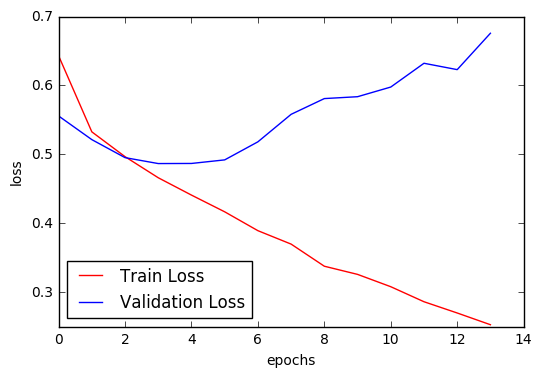

In [326]:
attention_train_loss = history_attention.history["loss"]
attention_val_loss = history_attention.history["val_loss"]
plt.plot(range(len(attention_train_loss)), attention_train_loss, color="red", label="Train Loss")
plt.plot(range(len(attention_train_loss)), attention_val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

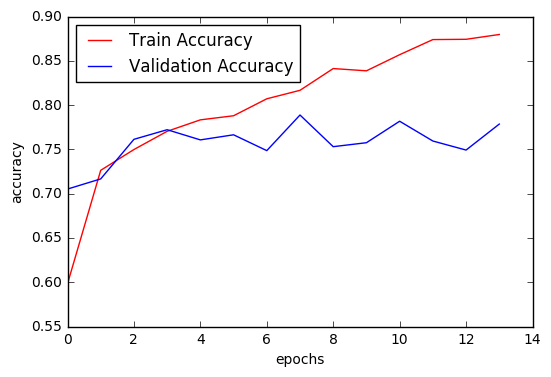

In [327]:
attention_train_acc = history_attention.history["acc"]
attention_val_acc = history_attention.history["val_acc"]
plt.plot(range(len(attention_train_acc)), attention_train_acc, color="red", label="Train Accuracy")
plt.plot(range(len(attention_train_acc)), attention_val_acc, color="blue", label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

In [328]:
attention_model.load_weights(attention_weight_file)
attention_predicted = attention_model.predict(test_data)
label_encoder = LabelEncoder()
# y_tru, static_y_te = final_labels(test_label, static_predicted, 0.49)
y_tru, attention_y_te = final_labels2(test_label, attention_predicted)
# print(len(y_tru))
# print(len(y_te))
attention_y_te = label_encoder.fit_transform(attention_y_te)
y_tru = label_encoder.fit_transform(y_tru)
# print(y_te[:100])
# print(y_tru[:100])
report(label_encoder, y_tru, attention_y_te)

Classifation Report
{'negative': 0, 'positive': 1}
             precision    recall  f1-score   support

   negative       0.44      0.78      0.56       597
   positive       0.94      0.78      0.86      2763

avg / total       0.85      0.78      0.80      3360

Confusion matrix
['negative' 'positive']
[[ 465  132]
 [ 600 2163]]
Micro:  p: 0.7821 r: 0.7821 f1: 0.7821
Macro:  p: 0.6896 r: 0.7809 f1: 0.7074
Weight: p: 0.8526 r: 0.7821 f1: 0.8027
Test Accuracy: 0.7821
ROC AUC: 0.781
Misclassified samples: 732


/home/niloofarsafi/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
